In [1]:
import numpy as np
import matplotlib.pyplot as plt
from architecture.Model import Model
from dataloader.Dataloader import *
from train.Trainer import *
import torch
from munch import Munch

In [2]:
#argparser doesnt work for jupyter notebook
params = Munch({
    'img_size': 256,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'batch_size': 8,
    'style_dim': 64,
    'eval_iter': 50,
    'save_iter': 500,
    'lambda_ds': 1.0,
    'resume_iter': 0,
    'max_iter': 250,
    'mode': 'train',
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-2,
    'checkpoint_dir': '',
    'log_iter': 5,
    'epochs' : 100,
    'fan_pretrained_fname' : None#"architecture/FAN/weights.pth"
})

In [3]:
root = "../shared/stargan_folder/data/celeba_hq/train" #if gpu server
#Model,CopyModel = Model(params)

#restart gpu memory
#torch.cuda.empty_cache()

trainer = Trainer(params)

train_loader = get_loader(root, params.batch_size, params.img_size, num_files=500)
loaders = Munch(train=train_loader)

Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...


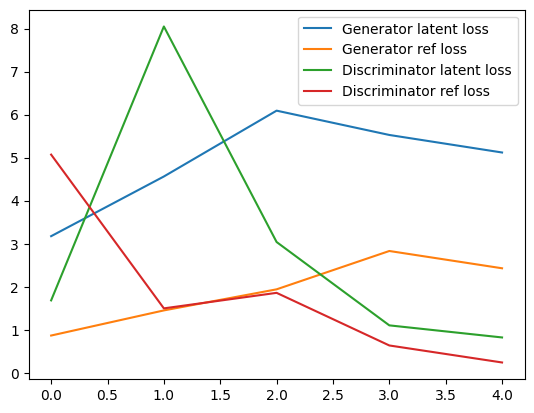

Time elapsed : 0:00:12.131777
Epoch : 0/100, Batch 5/63


KeyboardInterrupt: 

In [4]:
trainer.train(loaders)

In [22]:
from torchvision.utils import make_grid

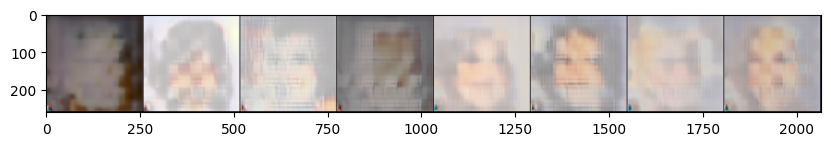

In [12]:
generator = trainer.networks.generator
mn = trainer.networks.mapping_network

train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y
z1, z2 = inputs.z1, inputs.z2
x_ref1, x_ref2 = inputs.x_ref1, inputs.x_ref2
y_trg = inputs.y_trg

style = mn(z1,y_trg)
input_img=x_org

x_fake=generator(input_img,style)

x_n = [(x-x.min())/(x.max()-x.min()) for x in x_fake]
#normalize_tensor(x_fake)

grid = make_grid(x_n)



imgs=torch.permute(grid, [1,2,0]).cpu().detach().numpy()

#fake_img=torch.permute((x_fake+1)/2, [1,2,0]).cpu().detach().numpy()

plt.figure(figsize=(10,5))
plt.imshow(imgs)
plt.show()


In [33]:
x_n = [(x-x.min())/(x.max()-x.min()) for x in x_fake]

#x_n = (x-x.min())/(x.max()-x.min())

x_n.max()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

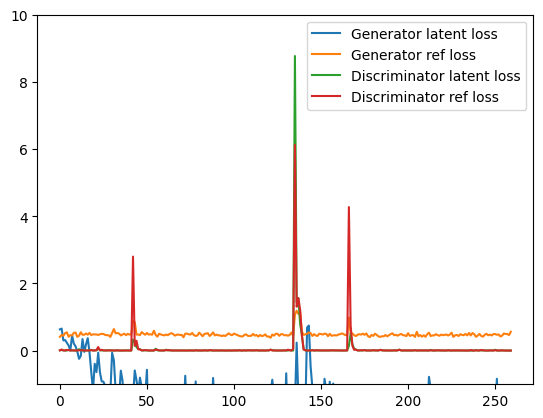

KeyboardInterrupt: 

In [9]:
#continue training from last iter = 1000
params.resume_iter=1000
params.max_iter=2000
params.lambda_ds=0.5 #
params

trainer=Trainer(params)
trainer.train(loaders)

In [ ]:
generator = trainer.networks_copy.generator
mn = trainer.networks_copy.mapping_network

train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y
z1, z2 = inputs.z1, inputs.z2
x_ref1, x_ref2 = inputs.x_ref1, inputs.x_ref2
y_trg = inputs.y_trg

style = mn(z1,y_trg)
input_img=x_org

x_fake=generator(input_img,style)[0]

fake_img=torch.permute((x_fake+1)/2, [1,2,0]).cpu().detach().numpy()

plt.imshow(fake_img)
plt.show()
